Import useful libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import tensorflow as tf 

Function calculating received power from transmitted power and distance

In [2]:
def rec_pow(Pt, λ, d0, eta, d):
    Pr = Pt + 20*math.log10(λ/(4*math.pi*d0)) + 10*eta*math.log10(d0/d)
    return Pr

Function for defining other variables and calling the function to calculate received power with distance and transmitted power values list

In [3]:
def get_rec_pow(d_list, pt_list):
    pr_list = []
    f = 3.5 #in GHz
    c = 0.3 # * 10^9 m/s
    λ = c/f
    eta = 3
    d0 = 1
    for d in d_list:
        for pt in pt_list:
            pr = rec_pow(pt, λ, d0, eta, d)
            pr_list.append(pr)
    return pr_list

Functions for distance and transmitted power

In [4]:
def normalize1(arr, t_min, t_max):
    norm_arr = []
    diff = t_max - t_min
    diff_arr = 500 - 30   
    for i in arr:
        temp = (((i - 30)*diff)/diff_arr) + t_min
        norm_arr.append(temp)
    return norm_arr

def normalize2(arr, t_min, t_max):
    norm_arr = []
    diff = t_max - t_min
    diff_arr = 43 - 20  
    for i in arr:
        temp = (((i - 20)*diff)/diff_arr) + t_min
        norm_arr.append(temp)
    return norm_arr

Get input data and print the data size

In [5]:
range_to_normalize = (0,1)
d_list = [d for d in range(30, 500)]
pt_list = [pt for pt in range(20, 43)]
y_list = np.array(get_rec_pow(d_list, pt_list))
x_d = normalize1(d_list, range_to_normalize[0], range_to_normalize[1])
x_pt = normalize2(pt_list, range_to_normalize[0], range_to_normalize[1])
x_l = []
for d in x_d:
    for pt in x_pt:
        x_l.append([d, pt])
x_list = np.array(x_l)
print(x_list.shape)
print(y_list.shape)

(10810, 2)
(10810,)


Train-Test-Validation Split

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_list, y_list, test_size = 0.2, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 42)

Import keras APIs

In [7]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, Activation, BatchNormalization, Lambda
from keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau

Model architecture using keras sequential model

In [8]:
model = Sequential()
model.add(Input(shape=(2,)))
model.add(Dense(128))
model.add(Activation('tanh'))
model.add(Dense(64))
model.add(Activation('tanh'))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               384       
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 activation_1 (Activation)   (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,705
Trainable params: 8,705
Non-trainable params: 0
_________________________________________________________________


Training the model

In [9]:
#es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 10)
model.compile(optimizer='sgd', loss='mse')
losses = model.fit(x_train, y_train, 
                   validation_data=(x_val, y_val),
                   batch_size=4, 
                   epochs=50,
                   #callbacks=[es]
                   )

Epoch 1/50
1946/1946 [==============================] - 4s 2ms/step - loss: 38.1807 - val_loss: 8.0861
Epoch 2/50
1946/1946 [==============================] - 3s 1ms/step - loss: 3.4507 - val_loss: 7.4249
Epoch 3/50
1946/1946 [==============================] - 3s 1ms/step - loss: 2.1862 - val_loss: 0.4260
Epoch 4/50
1946/1946 [==============================] - 3s 1ms/step - loss: 3.1252 - val_loss: 1.9966
Epoch 5/50
1946/1946 [==============================] - 3s 1ms/step - loss: 0.9947 - val_loss: 0.5333
Epoch 6/50
1946/1946 [==============================] - 3s 1ms/step - loss: 0.7872 - val_loss: 0.3710
Epoch 7/50
1946/1946 [==============================] - 3s 1ms/step - loss: 0.4015 - val_loss: 0.2015
Epoch 8/50
1946/1946 [==============================] - 3s 2ms/step - loss: 0.4589 - val_loss: 0.8494
Epoch 9/50
1946/1946 [==============================] - 3s 1ms/step - loss: 0.2646 - val_loss: 0.0907
Epoch 10/50
1946/1946 [==============================] - 3s 1ms/step - loss: 0.22

Visualize the DNN Model

In [10]:
# from ann_visualizer.visualize import ann_viz
# ann_viz(model, view=True, title="Model Architecture")

Testing the model on test data obtained using split

In [11]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import math
y_pred = model.predict(x_test)
MSE = mean_squared_error(y_test,y_pred)
RMSE = math.sqrt(MSE)
print("RMSE = ",RMSE)
R2 = r2_score(y_test, y_pred)
print("R2 score = ",R2)

68/68 [==============================] - 0s 1ms/step
RMSE =  0.4071227762450537
R2 score =  0.9986430251946058


In [12]:
print(y_pred[1])
print(y_test[1])

[-91.65442]
-91.00607913343913


For some distance and transmitted power values, get values of received power

In [13]:
distance = [30.5, 300.5, 495.5]
power = [p for p in range(22, 42, 2)]
rec = get_rec_pow(distance, power)
print(distance, power, rec)

[30.5, 300.5, 495.5] [22, 24, 26, 28, 30, 32, 34, 36, 38, 40] [-65.85212825345776, -63.852128253457764, -61.852128253457764, -59.852128253457764, -57.852128253457764, -55.852128253457764, -53.852128253457764, -51.852128253457764, -49.852128253457764, -47.852128253457764, -95.65846736321694, -93.65846736321694, -91.65846736321694, -89.65846736321694, -87.65846736321694, -85.65846736321694, -83.65846736321694, -81.65846736321694, -79.65846736321694, -77.65846736321694, -102.17444283769302, -100.17444283769302, -98.17444283769302, -96.17444283769302, -94.17444283769302, -92.17444283769302, -90.17444283769302, -88.17444283769302, -86.17444283769302, -84.17444283769302]


Getting test data by normalizing it

In [14]:
dis = normalize1(distance, range_to_normalize[0], range_to_normalize[1])
po = normalize2(power, range_to_normalize[0], range_to_normalize[1])
features = []
for d in dis:
    for p in po:
        features.append([d, p])
rec_pred = model.predict(np.array(features))
print(rec_pred)

1/1 [==============================] - 0s 32ms/step
[[ -66.08566 ]
 [ -64.2065  ]
 [ -62.161846]
 [ -60.132473]
 [ -58.071358]
 [ -55.802593]
 [ -54.11447 ]
 [ -52.046986]
 [ -49.847652]
 [ -47.721027]
 [ -95.76064 ]
 [ -93.76761 ]
 [ -92.000755]
 [ -90.22955 ]
 [ -88.175545]
 [ -86.05698 ]
 [ -84.51583 ]
 [ -82.295044]
 [ -79.99649 ]
 [ -77.85429 ]
 [-102.278595]
 [-100.17671 ]
 [ -98.3967  ]
 [ -96.31377 ]
 [ -94.25478 ]
 [ -92.57855 ]
 [ -90.87163 ]
 [ -88.74678 ]
 [ -86.5706  ]
 [ -85.04224 ]]


Plot for d = 30.5 m

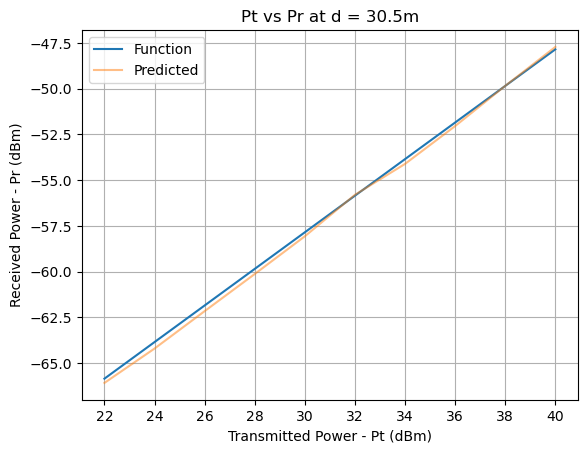

In [15]:
plt.plot(power,rec[:10], label="Function", alpha=1)
plt.plot(power,rec_pred[:10], label="Predicted", alpha=0.5)
plt.xticks(power)
plt.grid()
plt.xlabel("Transmitted Power - Pt (dBm)")
plt.ylabel("Received Power - Pr (dBm)")
plt.title("Pt vs Pr at d = 30.5m")
plt.legend()
plt.show()

Print MSE and R2

In [16]:
MSE = mean_squared_error(rec[:10],rec_pred[:10])
RMSE = math.sqrt(MSE)
print("MSE = ",MSE)
R2 = r2_score(rec[:10],rec_pred[:10])
print("R2 score = ",R2)

MSE =  0.052915019830866585
R2 score =  0.9983965145505798


Plot for d = 300.5 m

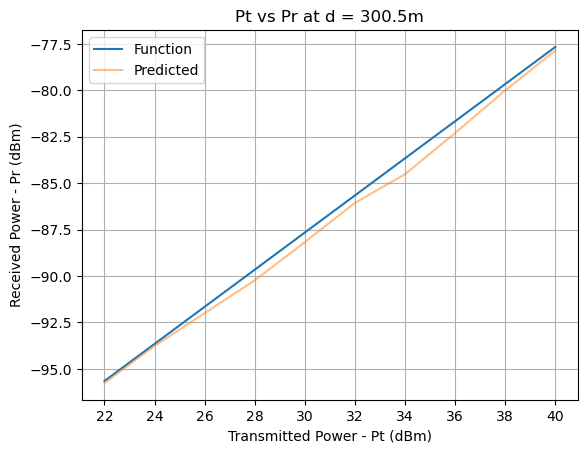

In [17]:
plt.plot(power,rec[10:20], label="Function", alpha=1)
plt.plot(power,rec_pred[10:20], label="Predicted", alpha=0.5)
plt.xticks(power)
plt.grid()
plt.xlabel("Transmitted Power - Pt (dBm)")
plt.ylabel("Received Power - Pr (dBm)")
plt.title("Pt vs Pr at d = 300.5m")
plt.legend()
plt.show()

Print MSE and R2

In [18]:
MSE = mean_squared_error(rec[10:20],rec_pred[10:20])
RMSE = math.sqrt(MSE)
print("MSE = ",MSE)
R2 = r2_score(rec[10:20],rec_pred[10:20])
print("R2 score = ",R2)

MSE =  0.21847369583235193
R2 score =  0.9933795849747772


Plot for d = 495.5 m

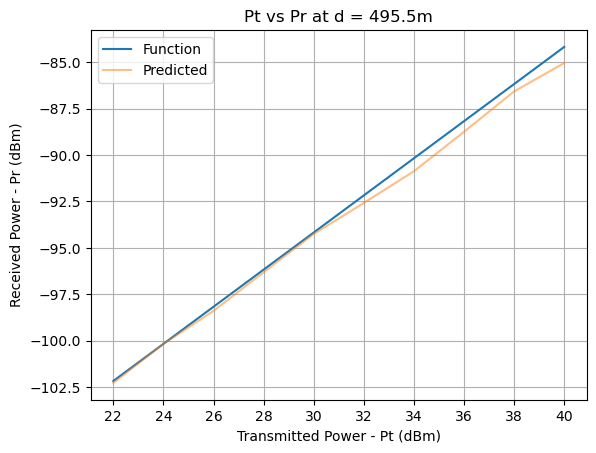

In [19]:
plt.plot(power,rec[20:30], label="Function", alpha=1)
plt.plot(power,rec_pred[20:30], label="Predicted", alpha=0.5)
plt.xticks(power)
plt.grid()
plt.xlabel("Transmitted Power - Pt (dBm)")
plt.ylabel("Received Power - Pr (dBm)")
plt.title("Pt vs Pr at d = 495.5m")
plt.legend()
plt.show()

Print MSE and R2

In [20]:
MSE = mean_squared_error(rec[20:30],rec_pred[20:30])
RMSE = math.sqrt(MSE)
print("RMSE = ",MSE)
R2 = r2_score(rec[20:30],rec_pred[20:30])
print("R2 score = ",R2)

RMSE =  0.1973065423146508
R2 score =  0.994021013869253
